In [1]:
import pandas as pd
import re

In [18]:
# df1_gln = pd.read_csv('/Volumes/LaCie/phospho_white_list/PXD006449/2021-08-24-14-06-06/Task2-search/Individual File Results/20130426_SK_SA_marta_phospho_8_gln_1_PSMs.psmtsv',sep='\t')

# df1 = pd.read_csv('/Volumes/LaCie/phospho_white_list/PXD006449/2021-08-24-14-06-06/Task2-search/Individual File Results/20130426_SK_SA_marta_phospho_8_1_PSMs.psmtsv',sep='\t')
# df1['dataset'] = 'PXD006449'

df1_gln = pd.read_csv('PXD006449/20130426_SK_SA_marta_phospho_8_gln_1_PSMs.psmtsv',sep='\t')

df1 = pd.read_csv('PXD006449/20130426_SK_SA_marta_phospho_8_1_PSMs.psmtsv',sep='\t')


# xls = pd.ExcelFile('/Volumes/LaCie/phospho_white_list/PXD000472/Supplementary_Dataset_1.xlsx')
xls = pd.ExcelFile('PXD000472/Supplementary_Dataset_1.xlsx')
df2 = pd.read_excel(xls, 'Phosphopeptide Features')


# df3 = pd.read_csv('PXD013503/Holz_MCF7_TMT_PP_01_17Nov17_Elm_AQ-17-10-03_msgfplus.tsv', sep='\t')
df3 = pd.read_excel('144972_1_supp_335637_prw13z.xlsx')


There are 3 datasets:

    PXD006449:
        3 growth conditions, 8hr and 24hr.
        MEM with gln - control
        MEM without gln - stress, loss of natural c source
        MEM with gln and Oligomyocin - tumor/hypoxia simulation

    PXD000472:
        2 air/temp conditions.
        control, 15 min, 2hr.

    PXD013503:
        Phosphoproteomic data from human MCF-7 cells treated with estrogen only or estrogen plus rapamycin, an mTOR inhibitor.


    Each one indicates modifications differently. 
        Metamopheus: [Common Biological:Phosphorylation on S]
        MSGFPlus: K.+229.163DEDS+79.966DDDDGS+79.966S+79.966AGC
        MaxQuant: SAS^PY^PSHSLS^SPQRPSHSLS^

We are going to format them using the S^ method. 

In [19]:
#S^ s is phosphorylated
#S+79
#[phos on S]

def format_MM_mod(row):
    peptide = row['Full Sequence']
    newpep = re.sub('\[.*?\]', "^",peptide)
    return newpep

# +229: TMT on N terminal
# Just get rid of this (the +229)
def format_msgf_mod(row):
#     import pdb;pdb.set_trace()
    peptide = row['Peptide']
    newpep = re.sub('\+[\d+\.]+', "^", peptide)
    if newpep[0:1] == '^':
        newpep = newpep[1:]
        
    return newpep

def format_013503_mod(row):
    peptide = row['Peptide']
    newpep = re.sub('\*', "^", peptide)
    #remove the .
    newpep = newpep[:-2]
    newpep = newpep[2:]
    if newpep[0:1] == '^':
        newpep = newpep[1:]
        
    return newpep
 

In [20]:
df1['peptide'] = df1.apply(format_MM_mod, axis=1)
df1_gln['peptide'] = df1_gln.apply(format_MM_mod, axis=1)
df2['peptide'] = df2['pSequence']
# df3['peptide'] = df3.apply(format_msgf_mod, axis=1)
df3['peptide'] = df3.apply(format_013503_mod, axis=1)



In [5]:
#Now they're all formated the same, lets get a list of intersecting peptides

In [21]:
df1_list = list(set(df1['peptide']) & set(df1_gln['peptide']))
df1_df2 = list(set(df1_list) & set(df2['peptide']))
df2_df3 = list(set(df2['peptide']) & set(df3['peptide']))
df1_df3 = list(set(df1_list) & set(df3['peptide']))
df1_df2_df3 = list(set(df1_list) & set(df2['peptide']) & set(df3['peptide']))

In [22]:
print(len(df1_list))
print(len(set(df2['peptide'])))
print(len(set(df3['peptide'])))

print()
print(len(set(df1_list).difference(*[list(df2['peptide'].unique()),list(df3['peptide'].unique())])))
print(len(set(df2['peptide'].unique()).difference(*[list(df1_list),list(df3['peptide'].unique())])))
print(len(set(df3['peptide'].unique()).difference(*[list(df1_list),list(df2['peptide'].unique())])))


print()
print(len(df1_df2))
print(len(df2_df3))
print(len(df1_df3))
print(len(df1_df2_df3))

4440
2977
10718

4013
2108
9901

287
677
235
95


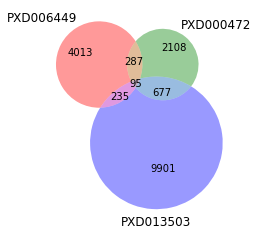

In [7]:
from matplotlib_venn import venn3
venn3(subsets = (4013, 2108 , 287,
                 9901,
                 235, 677,
                 95
                ), set_labels = ('PXD006449', 'PXD000472', 'PXD013503'))

## Get a list of all intersections

In [9]:
95+235+677

1007

In [9]:
all_inter = set(df2_df3 + df1_df3 + df1_df2_df3)
len(all_inter)

817

# Get intensities

In [3]:
import pyteomics
from pyteomics import mzml, auxiliary



In [55]:
def get_precursor_inten(row, mzml, col_scan_Name):
    scan = str(row[col_scan_Name])
    my_id = 'controllerType=0 controllerNumber=1 scan='+ str(scan)
    spectrum_dict = mzml.get_by_id(my_id)

    spectrum_id = spectrum_dict['id']
    retention_time = (spectrum_dict['scanList']['scan'][0].get('scan start time', -1))
    precursor = spectrum_dict['precursorList']['precursor'][0]
    precursor_ion = precursor['selectedIonList']['selectedIon'][0]
    precursor_mz = precursor_ion['selected ion m/z']
    if len(precursor_ion) >=3:
        precursor_intensity = precursor_ion['peak intensity']
    else: 
        precursor_intensity = "NAN"
    
    return precursor_intensity
def get_retention_time(row, mzml, col_scan_Name):
    scan = str(row[col_scan_Name])
    my_id = 'controllerType=0 controllerNumber=1 scan='+ str(scan)
    spectrum_dict = mzml.get_by_id(my_id)

    spectrum_id = spectrum_dict['id']
    retention_time = (spectrum_dict['scanList']['scan'][0].get('scan start time', -1))
    
    return retention_time

# PXD006449

In [110]:
PXD006449 = pd.read_csv('PXD006449/tsvs/20130426_SK_SA_marta_phospho_8_1.tsv', sep='\t')
pdx6449 = PXD006449[PXD006449['QValue'] <= .01]

pdx6449['peptide'] = pdx6449.apply(format_msgf_mod, axis=1)
mzml6449 = pyteomics.mzml.MzML('PXD006449/mzmls/20130426_SK_SA_marta_phospho_8_1.mzML')
pdx6449['precursor_intensity'] = pdx6449.apply(lambda row: get_precursor_inten(row, mzml6449, 'ScanNum'), axis=1)
pdx6449['retention_time'] = pdx6449.apply(lambda row: get_retention_time(row, mzml6449, 'ScanNum'), axis=1)

pdx6449_rep1 = pdx6449[['Protein', 'peptide','QValue', 'ScanNum', 'Precursor', 'precursor_intensity', 'retention_time']]

pdx6449_rep1.to_csv("PXD006449/pdx6449_rep1", sep='\t')

<ipython-input-110-2225e2d7d5f3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdx6449['peptide'] = pdx6449.apply(format_msgf_mod, axis=1)
<ipython-input-110-2225e2d7d5f3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdx6449['precursor_intensity'] = pdx6449.apply(lambda row: get_precursor_inten(row, mzml6449, 'ScanNum'), axis=1)
<ipython-input-110-2225e2d7d5f3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [75]:
PXD006449 = pd.read_csv('PXD006449/tsvs/20130426_SK_SA_marta_phospho_8_2.tsv', sep='\t')
pdx6449 = PXD006449[PXD006449['QValue'] <= .01]

pdx6449['peptide'] = pdx6449.apply(format_msgf_mod, axis=1)
mzml6449 = pyteomics.mzml.MzML('PXD006449/mzmls/20130426_SK_SA_marta_phospho_8_2.mzML')
pdx6449['precursor_intensity'] = pdx6449.apply(lambda row: get_precursor_inten(row, mzml6449, 'ScanNum'), axis=1)
pdx6449['retention_time'] = pdx6449.apply(lambda row: get_retention_time(row, mzml6449, 'ScanNum'), axis=1)

pdx6449_rep2 = pdx6449[['Protein', 'peptide','QValue', 'ScanNum', 'Precursor', 'precursor_intensity', 'retention_time']]


pdx6449_rep2.to_csv("PXD006449/pdx6449_rep2", sep='\t')

In [60]:
pdx6449Rep1_pnnl = list(set(pdx6449_rep1['peptide']) & set(df3['peptide']))
pdx6449Rep2_pnnl = list(set(pdx6449_rep2['peptide']) & set(df3['peptide']))

print(len(pdx6449Rep1_pnnl), len(pdx6449Rep2_pnnl))

500 304


In [89]:
#in both replicates and in pnnl study
pdx6449_in_all = list(set(pdx6449Rep1_pnnl) & set(pdx6449Rep2_pnnl))
print(len(pdx6449_in_all))

181


In [107]:
len(list(set(pdx6449Rep1_pnnl).union(set(pdx6449Rep2_pnnl))))

623

In [112]:
pdx6449_rep1 = pdx6449_rep1[pdx6449_rep1['peptide'].isin(pdx6449Rep1_pnnl)]
pdx6449_rep1 = pdx6449_rep1.sort_values('precursor_intensity', ascending=False) 
pdx6449_rep2 = pdx6449_rep2[pdx6449_rep2['peptide'].isin(pdx6449Rep2_pnnl)]
pdx6449_rep2 = pdx6449_rep2.sort_values('precursor_intensity', ascending=False) 



pdx6449_rep1.to_csv("PXD006449/PXD006449_rep1", sep='\t')
pdx6449_rep2.to_csv("PXD006449/PXD006449_rep2", sep='\t')

In [96]:
pdx6449_rep2


,Protein,peptide,QValue,ScanNum,Precursor,precursor_intensity,retention_time
0,"sp|P22626|ROA2_HUMAN(pre=R,post=G)",GFGDGYNGYGGGPGGGNFGGS^PGYGGGR,0.000000,55993,1288.01390,1.27361e+06,145.204910
1,"sp|P43307|SSRA_HUMAN(pre=K,post=R)",VEMGTSSQNDVDMSWIPQETLNQINKAS^PR,0.000000,80256,1152.53100,2.19076e+06,205.637550
2,"sp|Q8IYB3|SRRM1_HUMAN(pre=K,post=A)",KPPAPPS^PVQSQS^PSTNWSPAVPVKK,0.000000,43187,957.80680,979857,113.586570
3,"sp|P06733|ENOA_HUMAN(pre=K,post=F)",SFIKDYPVVSIEDPFDQDDWGAWQK,0.000000,87234,1493.21010,2.16843e+06,223.188150
4,"sp|P04406|G3P_HUMAN(pre=K,post=T)",VIHDNFGIVEGLM^TTVHAITATQK,0.000000,77121,653.59620,1.69217e+06,197.771340
...,...,...,...,...,...,...,...
11242,"sp|O95994|AGR2_HUMAN(pre=K,post=K)",TSNKPLMIIHHLDEC^PHSQALK,0.009958,25669,857.44037,247029,70.335208
11243,"sp|Q6ZRV2|FA83H_HUMAN(pre=R,post=E)",HLRPPQYVTR,0.009958,8777,422.90820,571661,28.131130
11244,"sp|P60228|EIF3E_HUMAN(pre=K,post=Y)",HGFRQEYLDTLYR,0.009958,31999,425.21720,184769,85.958851
11245,"sp|O75369|FLNB_HUMAN(pre=K,post=R)",FNDEHIPESPYLVPVIAPSDDAR,0.009958,67748,861.42926,320616,174.406110


# PXD000472

In [76]:
ctr472 = pd.read_csv('PXD000472/tsvs/b0775p96_Control_1.tsv', sep='\t')
ctr472 = ctr472[ctr472['QValue'] <= .01]

ctr472['peptide'] = ctr472.apply(format_msgf_mod, axis=1)
mzml472 = pyteomics.mzml.MzML('PXD000472/mzmls/b0775p96_Control_1.mzML')
ctr472['precursor_intensity'] = ctr472.apply(lambda row: get_precursor_inten(row, mzml472, 'ScanNum'), axis=1)
ctr472['retention_time'] = ctr472.apply(lambda row: get_retention_time(row, mzml472, 'ScanNum'), axis=1)


ctr472_1 = ctr472[['ScanNum','peptide','Protein','QValue','retention_time','Precursor','precursor_intensity']]

ctr472_1.to_csv("PXD000472/ctr472_1", sep='\t')

In [77]:
ctr472 = pd.read_csv('PXD000472/tsvs/b0775p96_Control_2.tsv', sep='\t')
ctr472 = ctr472[ctr472['QValue'] <= .01]

ctr472['peptide'] = ctr472.apply(format_msgf_mod, axis=1)
mzml472 = pyteomics.mzml.MzML('PXD000472/mzmls/b0775p96_Control_2.mzML')
ctr472['precursor_intensity'] = ctr472.apply(lambda row: get_precursor_inten(row, mzml472, 'ScanNum'), axis=1)
ctr472['retention_time'] = ctr472.apply(lambda row: get_retention_time(row, mzml472, 'ScanNum'), axis=1)


ctr472_2 = ctr472[['ScanNum','peptide','Protein','QValue','retention_time','Precursor','precursor_intensity']]

ctr472_2.to_csv("PXD000472/ctr472_2", sep='\t')

In [78]:
ctr472 = pd.read_csv('PXD000472/tsvs/b0775p96_Control_3.tsv', sep='\t')
ctr472 = ctr472[ctr472['QValue'] <= .01]

ctr472['peptide'] = ctr472.apply(format_msgf_mod, axis=1)
mzml472 = pyteomics.mzml.MzML('PXD000472/mzmls/b0775p96_Control_3.mzML')
ctr472['precursor_intensity'] = ctr472.apply(lambda row: get_precursor_inten(row, mzml472, 'ScanNum'), axis=1)
ctr472['retention_time'] = ctr472.apply(lambda row: get_retention_time(row, mzml472, 'ScanNum'), axis=1)


ctr472_3 = ctr472[['ScanNum','peptide','Protein','QValue','retention_time','Precursor','precursor_intensity']]

ctr472_3.to_csv("PXD000472/ctr472_3", sep='\t')

In [79]:
ctr472 = pd.read_csv('PXD000472/tsvs/b0775p96_Control_4.tsv', sep='\t')
ctr472 = ctr472[ctr472['QValue'] <= .01]

ctr472['peptide'] = ctr472.apply(format_msgf_mod, axis=1)
mzml472 = pyteomics.mzml.MzML('PXD000472/mzmls/b0775p96_Control_4.mzML')
ctr472['precursor_intensity'] = ctr472.apply(lambda row: get_precursor_inten(row, mzml472, 'ScanNum'), axis=1)
ctr472['retention_time'] = ctr472.apply(lambda row: get_retention_time(row, mzml472, 'ScanNum'), axis=1)


ctr472_4 = ctr472[['ScanNum','peptide','Protein','QValue','retention_time','Precursor','precursor_intensity']]

ctr472_4.to_csv("PXD000472/ctr472_4", sep='\t')

In [113]:
all_list = [ctr472_1['peptide'].unique(),ctr472_2['peptide'].unique(),ctr472_3['peptide'].unique(),ctr472_4['peptide'].unique()]
all_list = [item for sublist in all_list for item in sublist]

pxd472_pnnl = list(set(all_list) & set(df3['peptide']))

ctr1 = ctr472_1[ctr472_1['peptide'].isin(pxd472_pnnl)]
ctr2 = ctr472_2[ctr472_2['peptide'].isin(pxd472_pnnl)]
ctr3 = ctr472_3[ctr472_3['peptide'].isin(pxd472_pnnl)]
ctr4 = ctr472_4[ctr472_4['peptide'].isin(pxd472_pnnl)]


ctr1.to_csv("PXD000472/PXD000472_rep1", sep='\t')
ctr2.to_csv("PXD000472/PXD000472_rep2", sep='\t')
ctr3.to_csv("PXD000472/PXD000472_rep3", sep='\t')
ctr4.to_csv("PXD000472/PXD000472_rep4", sep='\t')

In [100]:
len(ctr4)

306

In [105]:
first_and_sec = set(set(ctr1['peptide']) & set(ctr2['peptide']))
all_4repl = set(set(first_and_sec) & set(ctr3['peptide']))
all_4repl = set(set(all_4repl) & set(ctr4['peptide']))
len(all_4repl)

110

In [102]:
all_list = [ctr1['peptide'].unique(),ctr2['peptide'].unique(),ctr3['peptide'].unique(),ctr4['peptide'].unique()]
all_list = [item for sublist in all_list for item in sublist]

len(set(all_list))

435